
# <span style="color:rgb(213,80,0)">A brief overview of MRI\-related data sets</span>

In this chapter we wiil briefly review the kinds of data one can encounter when dealing with diffusion MRI. If you're already familiar with diffusion MRI, you can probably skip this chapter.


As a general rule, diffusion MRI images are tomography volumes, meaning they are 3\-D volumes represented as a stack of slices in axial, sagittal or coronal arrangements. Diffusion MRI is obtained by modifying a basic T2\-weighted sequence with a couple of so\-called "pulsed gradients" with an inversion RF pulse in between. As opposed to T1\- or T2\-weighted images, the information diffusion MRI provides is **quantitative**, which allows to carry out numerical studies voxel\-by\-voxel or region\-based.


Raw diffusion data (at least brain diffusion MRI) is not directly usable as it comes out from the MRI magnet, so that several post\-proessing steps are required to interpret diffusion pheomena and extract quantitative indices. This is how different MRI contrasts, including diffusion weighted, look like compared to each other:

<p style="text-align:left">
   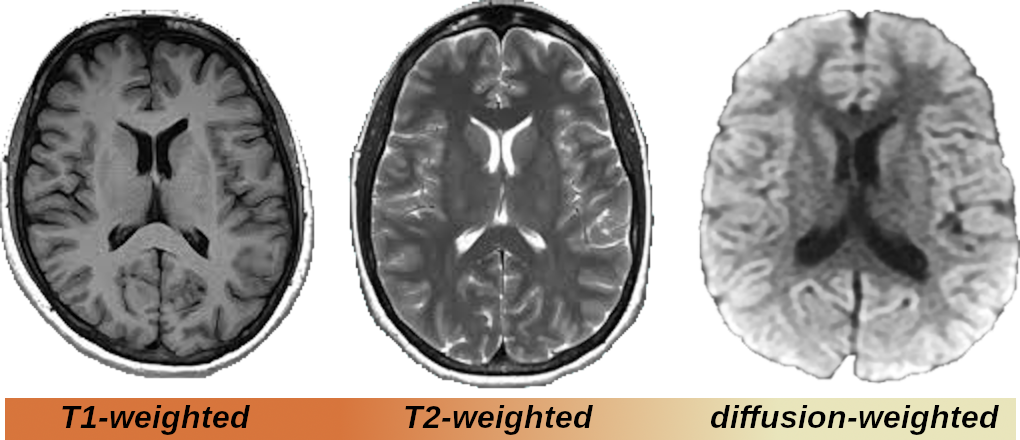
</p>


 ***TO DO:*** Clear all variables and figures to start from zero (*Ctrl+ENTER*):


In [ ]:
addpath('..');
setup__DMRIMatlab_toolbox;
clear;
close('all');

## 1. Diffusion Weigthed Images and attenuation images
### 1.1. Diffusion Weighted Images and diffusion gradients

Diffusion weighted images are the "raw images" acquired by the MRI device. The diffusion sequence introduces two strong, but short in time, sensitizing "gradients" (i.e. linear variations of the magnetic fields across the field of view of the image) to probe diffusion. To cut a long story short:

-  If the water molecules inside a voxel can move easily along the direction of the diffusion gradient, then the signal (gray level) of this voxel will attenuate noticeably w.r.t. a standard T2\-weighted signal (which is called a "baseline image").
-  If the water molecules insider a voxel hardly move along the direction of the diffusion gradient, then the acquired signal (gray level) of this voxel will be nearly the same as in the baseline, T2\-weighted image.

This way, by acquiring diffusion\-weighted images for different gradient orientations we can infer the anisotropic, directional behavior of different tissues, which is in turn related to their micro\- and meso\-structure.


The diffusion gradients are characterized by:

-  Their spatial orientation, typically referred to as $g_i$ , which is just a 3\-D unit vector, something like \[0,0,1\]. The directions of each of the $G$ diffusion gradients acquired in a diffusion MRI session are usually stacked in a $G\times 3$ matrix or "gradients table".
-  Their strength, i.e. how much the magnetic field varies end\-to\-end within the field of view of the image. This is usually called the "b\-value" of the acquisition, or simply $b_i$ , its units are $s/mm^2$ , and its usual values are in the range of few thousands.
### 1.2. Attenuation images

The raw Diffusion Weighted Images are not easy to interpret because their gray levels (pixel values) are the result of both the diffusion properties and the actual value of the non\-diffusion weighted T2 baseline image. To isolate the former effect, it is common to work with the attenuation images instead, i.e. the Diffusion Weighted Images normalized by the baseline image:


$$E(g_i ,b_i )=\frac{S(g_i ,b_i )}{S_0 }$$

Since this is an attenuation, its value should be in the range \[0,1\], so that their interpretation is easier (yet, due to noise and artifacts, its value might become greater than 1 in certain scenarios).

### 1.3. How does all of this work?

Let's load some test data and check their contents (*Ctrl+ENTER*):


In [ ]:
whos -file test_data3.mat
load test_data3.mat


You can check that the attenuation signal <samp>atti</samp> is a 4\-D volume. Why? MRI are 3\-D images, so that the first three dimensions of <samp>atti</samp>:


In [ ]:
size(atti,1),
size(atti,2),
size(atti,3),
size(mask)


are the pixel dimensions of the field of view. Note they match the dimensions of the variable <samp>mask</samp>, which is a 3\-D binary image that segments the actual information inside the brain from the background.


W.r.t. the 4th dimension of <samp>atti</samp>, note its size matches the number of rows of both <samp>gi</samp> (the gradients table) and <samp>bi</samp> (the gradients strengths):


In [ ]:
size(atti,4),
size(gi,1),
size(bi,1),


This means that the diffusion MRI volume has been acquired using <samp>size(gi,1)</samp> different gradients. Each of them results in a different DWI volume which is arranged in a new channel in the 4\-th dimension of the array, and then normalized by the baseline image to get the attenuation signal. Let's take a look to the actual look of these attenuation signals:


In [ ]:
close(figure(1));
hf1 = figure(1); % Create a new figure
set(hf1,'Position',[1,1,1200,400]);
channels = [65,68,71,74,77,80]; % "Gradient images" to show
slice = round(size(atti,3)/2); % Central slice
tiledlayout( 1, length(channels), 'TileSpacing', 'none' );
for k=1:length(channels)
    nexttile;
    channel = channels(k);
    % Eliminate the background multiplying by the mask:
    img = atti(:,:,slice,channel).*mask(:,:,slice);
    % Transpose the image (swap xy -> ji) to meet Matlab
    % convention:
    imshow( img', [0,1] );
end
drawnow;


***QUIZ:***

-  *Why the cerebrospinal fluid looks the same (black) in all attenuation images?*
-  *Some regions of the image look the same for all channels, some change from channel to channel. Which ones correspond to gray matter or white matter? Why?*
## 2. Some insights in the gradients table and b\-values

OK, so each channel of the attenuation signal corresponds to one entry in the gradients table ( **meaning:** <u>you always need a gradients table to be able to interpret the attenuation signal itself</u>). But, how this gradients table looks like? First, let's take a look to the b\-values we have acquired (remember they are measured in $s/mm^2$ ) (*Ctrl+ENTER*):


In [ ]:
unique(bi)',


So we have a cluster of "gradient" images acquired at nearly $b=1,000s/mm^2$ , some at nearly $b=2,000s/mm^2$ , some at nearly $b=3,000s/mm^2$ . When several (non\-null) different b\-values are acquired, the acquisition is called a "multi\-shell" one.


 ***QUIZ:***


 *Can you identify the clusters of b\-values, i.e. the shells of the acquisition? HINT: Check the function* *<samp>auto_detect_shells</samp>**.*

<pre>
help auto_detect_shells
</pre>

Let's take a look to the directions acquired nearly $b=1,000s/mm^2$ :


In [ ]:
close(figure(2));
hf2 = figure(2);
% Select the gradients we are interested in:
shell1 = ( (bi>500) & (bi<1500) );
plot3( gi(shell1,1), gi(shell1,2), gi(shell1,3), ...
    'LineStyle', 'none', 'Color', [.5,.0,.0], ...
    'Marker', '.', 'MarkerSize', 20 );
axis('equal');
rotate3d('on'); % Drag the mouse over the figure;


As you can see, the gradient directions are acquired so that a uniform coverage of one hemisphere is attained. IMPORTANTLY: the diffsuion sequence can distinguish spatial directions, but not the two orientations of each one of them. In other words, the Diffusion Weighted Image acquired for a gradient direction <samp>gi</samp> is virtually identical to that acquired for <samp>-gi</samp>. Of course, we can repeat the same representation for the three clusters of b\-values:


In [ ]:
close(figure(3));
hf3 = figure(3);
hold('on');
% Select the gradients we are interested in:
shell1 = ( (bi>500) & (bi<1500) );
plot3( gi(shell1,1)*1000, gi(shell1,2)*1000, gi(shell1,3)*1000, ...
    'LineStyle', 'none', 'Color', [.5,.0,.0], ...
    'Marker', '.', 'MarkerSize', 20 );
shell2 = ( (bi>1500) & (bi<2500) );
plot3( gi(shell1,1)*2000, gi(shell1,2)*2000, gi(shell1,3)*2000, ...
    'LineStyle', 'none', 'Color', [.0,.5,.0], ...
    'Marker', '.', 'MarkerSize', 20 );
shell3 = ( (bi>2500) & (bi<3500) );
plot3( gi(shell1,1)*3000, gi(shell1,2)*3000, gi(shell1,3)*3000, ...
    'LineStyle', 'none', 'Color', [.0,.0,.5], ...
    'Marker', '.', 'MarkerSize', 20 );
axis('equal');
rotate3d('on'); % Drag the mouse over the figure;


and now it becomes clear why we call these acquisitions "shells". Remember each point in the figure corresponds to an entire MRI volume that has to be acquired.


***QUIZ:***


 *Can you design and represent your own multi\-shell gradients table?*  ***HINT:***  *take a look to the function* *<samp>designGradients</samp>**:*

<pre>
help designGradients
</pre>

## 3. Diffusion Tensor Volumes

As you have seen above, the DWI volumes are not easy to interpret by themselves. This is why diffusion signal representations or biological models arised. Recall that a diffusion tensor can de identified with a $3\times 3$ , symmetric matrix:

<p style="text-align:left">
   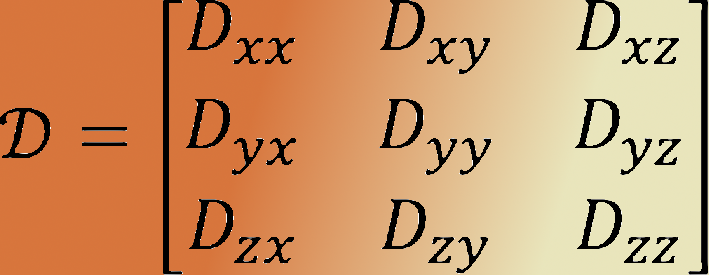
</p>


Since the tensor contains only 6 different values, it is usual to store only these values rasterized: $D_{xx} ,D_{xy} ,D_{xz} ,D_{yy} ,D_{yz} ,D_{zz}$ . Let's check it (*Ctrl+ENTER*):


In [ ]:
load test_data4.mat
whos -file test_data4.mat


The variable <samp>dti</samp> is a volume that contains an already estimated diffusion tensor volume. Note the first three dimensions correspond to the size of the field of view (as always) meanwhile the fourth one, with size 6, stacks the 6 free components (different values) of the diffusion tensor at each voxel. For example, let's pick up some random pixel of this volume, then re\-arrange these 6 components into a $3\times 3$ matrix:


In [ ]:
D = dti(35,23,23,:);
D = [ ...
    D(1), D(2), D(3); ...
    D(2), D(4), D(5); ...
    D(3), D(5), D(6)  ],


The eigenvectors and eigenvalues of this matrix are, respectively, the main diffusion directions inside the voxel and the amount of diffusion along each of these directions (in $mm^2 /s$ ):


In [ ]:
[U,L] = eig(D);
% Main diffusion direction and amount of diffusion along it:
u1 = U(:,3)', l1 = L(3,3), % Note the 3rd eigenvalue is the largest one
% Sencondary diffusion direction and amount of diffusion along it:
u2 = U(:,2)', l2 = L(2,2),
% Third diffusion direction and amount of diffusion along it:
u3 = U(:,1)', l3 = L(1,1), % Note the 1st eigenvalue is the smallest one


***QUIZ:***


 *Can you compute the eigenvectors and eigenvalues at the selected voxel* *<samp>(35,23,23)</samp>* *without arranging the* $3\times 3$ *matrix, then calling* *<samp>eig</samp>* *, then re\-arranging the result?* ***HINT:*** *take a look to the function* *<samp>dti2spectrum:</samp>*

<pre>
help dti2spectrum
</pre>

## 4\- Other type of diffusion\-derived volumes

Diffusion tensor is just the beginning. Of course, different signal representations and different bilogical models have their own rules and their own data types. For example, the "MiSFIT" representation uses two diffusivity parameters, one for the parallel direction, one for the perpendicular one, each one with the size of the field of view (*Ctrl+ENTER*):


In [ ]:
size(lpar),
size(lperp),


Besides, an additional "Spherical Harmonics" volume, <samp>shodf</samp>, provides a set of coefficients that are use to reconstruct the so\-called "Orientation Distribution Function", which generalizes the "main diffusion direction" (eigenvector associated to the largest eigenvalue) of the diffusion tensor. Take a look to its size:


In [ ]:
size(shodf),


As always, the first 3 dimensions correspond to the field of view, while the fourth accounts for 28 rasterized coefficients analogous to the 6 free coefficients of the diffusion tensor.


***QUIZ:***


 *Why 28 coefficients?*  ***HINT:***  *Take a look to the function* *<samp>GenerateSHCoefficients</samp>* *. Try to use it with some of the gi gradient tables you have designed above with* *<samp>designGradients</samp>* *and for different values of* *<samp>L</samp>**.*

<pre>
help GenerateSHCoefficients
</pre>

[Go back to index page](./tour_01intro.ipynb)


[Previous](./tour_01intro.ipynb)


[Next](./tour_03dtmri.ipynb)

